In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from time import time
from tqdm import trange, tqdm
%load_ext line_profiler

# Exam 2021 - Partial solution

This notebook contains a partial solution to the exam in TFY4235/FY8904 Computational Physics, spring 2021. The actual solution should take the form of a report, and should contain a description of the implementation and choices made. This partial solution only has the code, the figures that are asked for, and some brief points of discussion.

## Problem 2A

In [2]:
# Standard 4th-order Runge-Kutta integrator
def rk4(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    # "Slopes"
    k1  = f(x,          t)
    k2  = f(x + k1*h/2, t + h/2)
    k3  = f(x + k2*h/2, t + h/2)
    k4  = f(x + k3*h,   t + h)
    # Update time and position
    x_  = x + h*(k1 + 2*k2 + 2*k3 + k4)/6
    return x_

# Function to repeatedly call integrator and store results
def run_deterministic(X0, Tmax, h, f, integrator):
    # Number of timesteps
    Nt   = int((Tmax) / h)
    # Add 2 for initial position and fractional step at end
    # X0.size lets X hold Nt+2 arrays of the same size as X0
    X0   = np.array(X0)
    X    = np.zeros((Nt+2, X0.size))
    T    = np.zeros(Nt+2)
    # Initialise
    X[0,:] = X0
    T[0]   = 0
    # Loop over timesteps
    t = 0
    for i in range(Nt+1):
        # Make sure the last step stops exactly at Tmax
        h  = min(h, Tmax - t)
        # Calculate next position
        X[i+1,:] = integrator(X[i,:], t, h, f)
        T[i+1] = T[i] + h
        # Increment time
        t += h
    return X, T

# This function implements the right-hand side of Eqs. (1)
# (see the problem set)
def SIR_deterministic(X, t, beta, tau):
    # X is a three-component vector:
    # X = [S, I, R]
    S, I, R = X
    N = S + I + R
    dS = -beta*I*S/N
    dI =  beta*I*S/N - I/tau
    dR = I/tau
    return np.array([dS, dI, dR])

# This function provides a numerical approximation
# of S(\infty), given by Eq. (2a) in the problem set
def S_final(beta, tau):
    s = 0.5
    diff = 10
    while diff > 1e-14:
        s_ = np.exp(-beta*tau*(1-s))
        diff = np.abs(s_ - s)
        s = s_
    return s

# This function provides a numerical approximation
# of R(\infty), given by Eq. (2b) in the problem set
def R_final(beta, tau):
    r = 0.5
    diff = 10
    while diff > 1e-14:
        r_ = 1 - np.exp(-beta*tau*r)
        diff = np.abs(r_ - r)
        r = r_
    return r

## Problem 2A - Deciding on a timestep

Before proceeding, decide on a timestep. There are many ways to do this. One is to use $R(\infty)$ and $S(\infty)$ as references. However:
*  $S(\infty)$ and $R(\infty)$ are only valid when $R(0)=0$ and $I(0)$ is very, very close to zero
*  $S(\infty)$ and $R(\infty)$ are only valid for $t\infty$, which means we need to run the simulation until $I(t)$ is very close to zero.

Below, we start with $I(0) = 10^{-12}$, and run until 1000 days, and do a convergence test with the 4th-order Runge -Kutta method. We essentially find that any timestep less than 10 days seem to give acceptable results (for these parameters). Since 10 days is the typical duration of the disease, it seems reasonable to select a timestep that is quite a bit smaller than this, and the simulations are plenty fast with a timestep of 0.1 days, so we'll go for that for now.

To decide on a timestep, you could also run with a few different timesteps, and either observe that there is very little change, or you could use a numerical solution with a very short timestep as a reference and to a more quantitative test like the one below. There are many valid approaches. The main point is to show that you have thought critically about your choice of timestep.

In [3]:
# Probability of transmission
beta = 0.25
# Duration of illness
tau = 10

# Right-hand side of ODE
f = lambda x, t: SIR_deterministic(x, t, beta, tau)

# initial conditions
I0 = 1e-12 # I0 must be quite small if we are to compare to R(\infty) and S(\infty)
R0 = 0.0
S0 = 1 - I0 - R0

# Put into vector and calculate N
X0 = np.array([S0, I0, R0])
N = np.sum(X0)

# Simulation time (must be quite long if we are to compare to R(\infty) and S(\infty))
Tmax = 1000 # Time in days

# Reference solutions
S_ref = S_final(beta, tau)
R_ref = R_final(beta, tau)

# List of timesteps to test (in days)
timesteps = np.array([1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 2, 5, 10, 20])

# Lists to store errors
S_errors = np.zeros_like(timesteps)
R_errors = np.zeros_like(timesteps)

for i, dt in tqdm(enumerate(timesteps), total = len(timesteps)):
    # Run simulation
    X, T = run_deterministic(X0, Tmax, dt, f, rk4)
    # Unpack variables
    S, I, R = X.T
    # Store errors
    S_errors[i] = np.abs(S[-1] - S_ref)
    R_errors[i] = np.abs(R[-1] - R_ref)

100%|██████████| 11/11 [00:06<00:00,  1.70it/s]


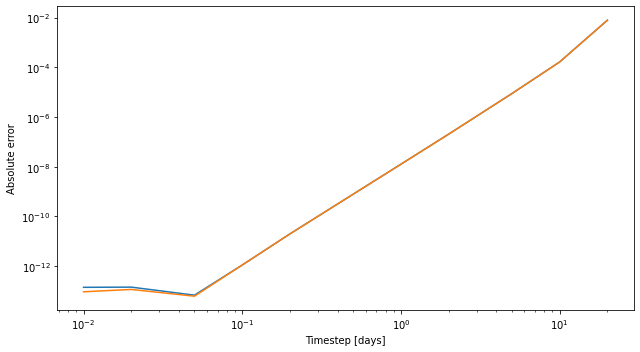

In [4]:
fig = plt.figure(figsize = (9, 5))
plt.plot(timesteps, S_errors)
plt.plot(timesteps, R_errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timestep [days]')
plt.ylabel('Absolute error')
plt.tight_layout()

## Problem 2A - Deciding on a tolerance

If you use a library integrator such as ```scipy.integrate.odeint```, there is no timestep to set, but there is a tolerance parameter. The default is probably perfectly ok, but we can check this just to be sure.

Note that the list of times to provide output at have nothing to do with the timestep used by the integrator. The integrator is adaptive, and chooses the timestep based on the estimated local error. It then uses a dense output scheme to interpolate the solution to the requested list of times. See Notebook 09 on ODEs where an example of this is shown.

The code below uses the same approach as above, using $R(\infty)$ and $S(\infty)$ as references. However, here as well there are many valid approaches, and again, the point is to show that you have thought about this.

Conclusions from the test below are that almost any tolerance smaller than about $10^{-4}$ should do nicely, and the simulations are anyway extremely fast, so we'll just use the default tolerance ($1.49012 \times 10^{-8}$). Also, since this approach is (not unsurprisingly) far faster than the home-cooked 4th-order Runge-Kutta, we'll use this for the other tasks.

In [5]:
from scipy.integrate import odeint

In [6]:
# Probability of transmission
beta = 0.25
# Duration of illness
tau = 10

# Right-hand side of ODE
f = lambda x, t: SIR_deterministic(x, t, beta, tau)

# initial conditions
I0 = 1e-12 # I0 must be quite small if we are to compare to R(\infty) and S(\infty)
R0 = 0.0
S0 = 1 - I0 - R0

# Put into vector and calculate N
X0 = np.array([S0, I0, R0])
N = np.sum(X0)

# Simulation time (must be quite long if we are to compare to R(\infty) and S(\infty))
Tmax = 1000 # Time in days

# Reference solutions
S_ref = S_final(beta, tau)
R_ref = R_final(beta, tau)

# List of tolerances to test
tolerances = np.array([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2])

# Lists to store errors
S_errors = np.zeros_like(tolerances)
R_errors = np.zeros_like(tolerances)

# List of times to provide solution at
# Note that this is unrelated to the timestep used by the integrator
T = np.linspace(0, Tmax, 1001)

for i, tol in tqdm(enumerate(tolerances), total = len(tolerances)):
    # Run simulation with scipy.integrate.odeint
    X = odeint(f, X0, T, atol = tol, rtol = tol)
    # Unpack variables
    S, I, R = X.T
    # Store errors
    S_errors[i] = np.abs(S[-1] - S_ref)
    R_errors[i] = np.abs(R[-1] - R_ref)

100%|██████████| 9/9 [00:00<00:00, 718.67it/s]


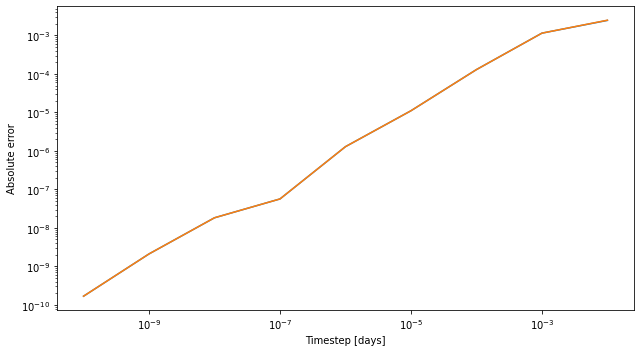

In [7]:
fig = plt.figure(figsize = (9, 5))
plt.plot(tolerances, S_errors)
plt.plot(tolerances, R_errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Timestep [days]')
plt.ylabel('Absolute error')
plt.tight_layout()

## Problem 2A  - Task a

In [8]:
# Probability of transmission
beta = 0.25
# Duration of illness
tau = 10

# Right-hand side of ODE
f = lambda x, t: SIR_deterministic(x, t, beta, tau)

# initial conditions
I0 = 1e-4
R0 = 0.0
S0 = 1 - I0 - R0

# Put into vector and calculate N
X0 = np.array([S0, I0, R0])
N = np.sum(X0)

# Simulation time
Tmax = 180 # Time in days

# List of times to provide solution at
# Note that this is unrelated to the timestep used by the integrator
T = np.linspace(0, Tmax, 1801) # 10 points per day

# Run simulation
X = odeint(f, X0, T)
# Unpack variables
S, I, R = X.T

S final (exact): 0.10736
S final (ODE):   0.10738
R final (exact): 0.89264
R final (ODE):   0.89250


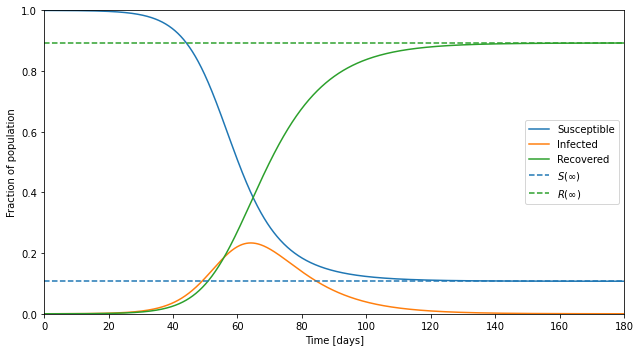

In [9]:
# Plot development
fig = plt.figure(figsize = (9, 5))

lS, = plt.plot(T, S/N, label = 'Susceptible')
lI, = plt.plot(T, I/N, label = 'Infected')
lR, = plt.plot(T, R/N, label = 'Recovered')

plt.plot([0, Tmax], S_final(beta, tau)*np.ones(2), '--', c = lS.get_color(), label = '$S(\infty)$')
plt.plot([0, Tmax], R_final(beta, tau)*np.ones(2), '--', c = lR.get_color(), label = '$R(\infty)$')

plt.legend()
plt.xlim(0, Tmax)
plt.ylim(0.0, 1.0)
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.tight_layout()

print(f'S final (exact): {S_final(beta, tau):.5f}')
print(f'S final (ODE):   {S[-1]/N:.5f}')

print(f'R final (exact): {R_final(beta, tau):.5f}')
print(f'R final (ODE):   {R[-1]/N:.5f}')

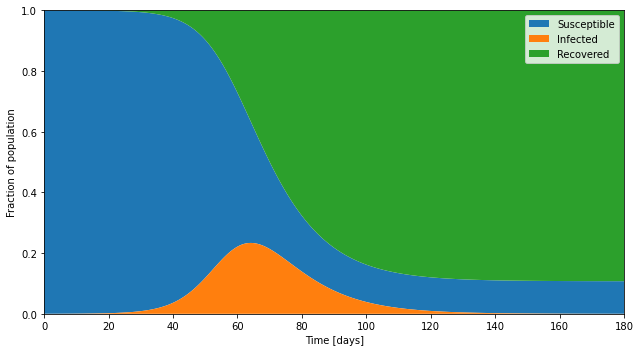

In [10]:
# Alternative plot of development
fig = plt.figure(figsize = (9, 5))

plt.fill_between(T, I/N, (S+I)/N, label = 'Susceptible')
plt.fill_between(T, 0, I/N, label = 'Infected')
plt.fill_between(T, (S+I)/N, (S+I+R)/N, label = 'Recovered')

plt.legend()
plt.xlim(0, Tmax)
plt.ylim(0.0, 1.0)
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.tight_layout()

## Problem 2A - Task b: Plot exponential growth

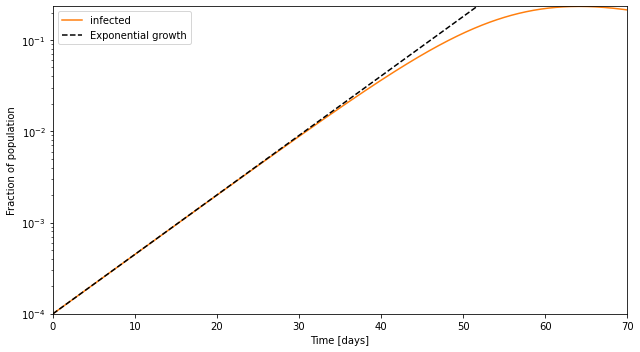

In [11]:
# Plot early phase infected on semi-log plot
fig = plt.figure(figsize = (9, 5))
plt.plot(T, I, c = '#ff7f0e', label = 'infected')
plt.plot(T, I0*np.exp(T*(beta-1/tau)), '--', c = 'k', label = 'Exponential growth')
plt.legend()
plt.yscale('log')
plt.xlim(0, 70)
plt.ylim(I0/N, np.amax(I)/N)
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.tight_layout()

## Problem 2A - Task c: Flattening the curve

### First, a visual approach

Just run a few simulations and plot on semi-log scale, to get an idea of what we're looking for.

In [12]:
# initial conditions
I0 = 1e-4
R0 = 0.0
S0 = 1 - I0 - R0
# Put into vector and calculate N
X0 = np.array([S0, I0, R0])
N = np.sum(X0)

# Simulation time and timestep
# Note that I set Tmax longer than strictly necessary,
# as otherwise the graph shows funny behaviour for the smallest betas.
# It takes much longer to reach the peak when beta is small,
# so the peak might occur after Tmax if it's too small.
# (In the end this doesn't actually affect the results, as the peak occurs
# earlier than 180 days for the value of beta that we are looking for.)
Tmax = 1000 # Time in days

# List of times to provide solution at
T = np.linspace(0, Tmax, 10001) # 10 points per day

# Transmission probabilities
betas = np.linspace(0.1, 0.5, 81)
# Duration of illness
tau = 10

I_peak = np.zeros_like(betas)
T_peak = np.zeros_like(betas)

for i, beta in tqdm(enumerate(betas), total = len(betas)):
    # Right-hand side of ODE
    f = lambda x, t: SIR_deterministic(x, t, beta, tau)
    # Run simulation
    X = odeint(f, X0, T)
    # Unpack variables
    S, I, R = X.T
    # Store maximal value of I (the peak)
    I_peak[i] = np.amax(I)
    # Store the time at which the peak occurs
    T_peak[i] = T[np.argmax(I)]

100%|██████████| 81/81 [00:00<00:00, 518.08it/s]


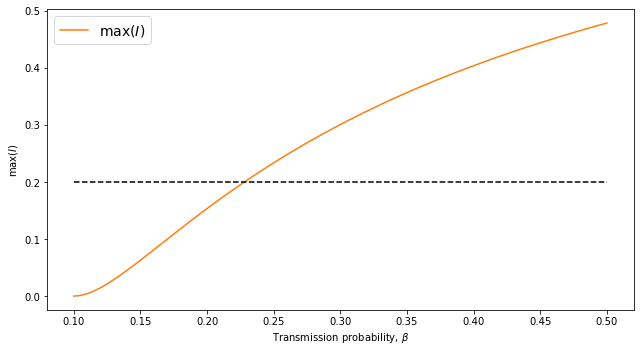

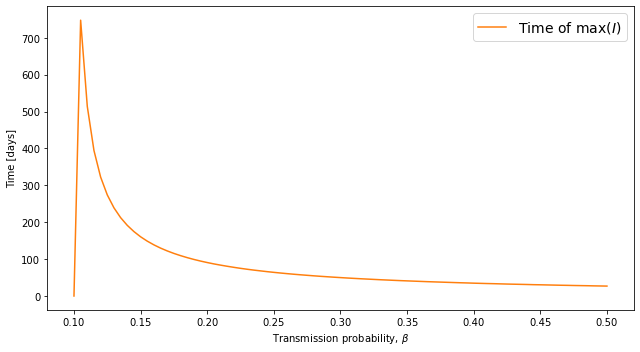

In [13]:
fig = plt.figure(figsize = (9, 5))
plt.plot(betas, I_peak, c = '#ff7f0e', label = '$\\max(I)$')
plt.plot(betas, [0.2]*len(betas), '--', c = 'k')
plt.xlabel('Transmission probability, $\\beta$')
plt.ylabel('$\\max(I)$')
plt.legend(fontsize = 14)
plt.tight_layout()

fig = plt.figure(figsize = (9, 5))
plt.plot(betas, T_peak, c = '#ff7f0e', label = 'Time of $\\max(I)$')
plt.xlabel('Transmission probability, $\\beta$')
plt.ylabel('Time [days]')
plt.legend(fontsize = 14)
plt.tight_layout()

### Then more rigorously with a bisection scheme

Using bisection scheme from ```scipy.optimize```. From the plot above, we know that the function we are looking at is strictly increasing, so there should be no difficulties. We also know that we can limit the search to values of $\beta$ around 0.2 to 0.25, and that integrating up to 180 days will suffice

In [14]:
from scipy.optimize import bisect

In [15]:
# The function to find the root of
def find_Imax(beta, target_value = 0.2, tau = 10, Tmax = 180):
    # initial conditions
    I0 = 1e-4
    R0 = 0.0
    S0 = 1 - I0 - R0
    # Put into vector and calculate N
    X0 = np.array([S0, I0, R0])
    # Right-hand side of ODE
    f = lambda x, t: SIR_deterministic(x, t, beta, tau)
    # List of times to provide solution at
    T = np.linspace(0, Tmax, 18001) # 100 points per day
    # Run simulation
    X = odeint(f, X0, T)
    # Unpack variables
    S, I, R = X.T
    # Return maximal value - target value
    return np.amax(I) - target_value

In [16]:
# Range to scan
beta_min = 0.2
beta_max = 0.25

# Run bisection scheme
print(f'beta = {bisect(find_Imax, beta_min, beta_max):.8f}')

beta = 0.22802090


## Problem 2A - Task d: Vaccines

### First a visual approach to get an idea

As before, we start out with making a plot for some range of values, to get an idea. We are interested finding out if the initial phase of the epedemic is growing, so we only need short runs (choosing 10 days).

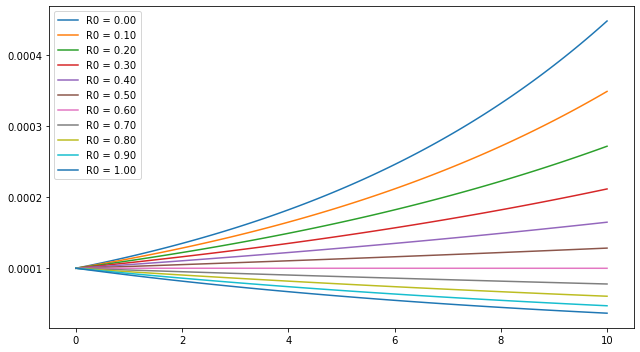

In [17]:
# Probability of transmission
beta = 0.25
# Duration of illness
tau = 10

# Simulation time and timestep
Tmax = 10 # Time in days
# List of times to provide solution at
T = np.linspace(0, Tmax, 101) # 10 points per day

R0s = np.linspace(0, 1, 11)

fig = plt.figure(figsize = (9, 5))

for i, R0 in enumerate(R0s):
    # initial conditions
    I0 = 1e-4
    S0 = 1 - I0 - R0
    # Put into vector
    X0 = np.array([S0, I0, R0])
    # Right-hand side of ODE
    f = lambda x, t: SIR_deterministic(x, t, beta, tau)
    # Run simulation
    X = odeint(f, X0, T)
    # Unpack variables
    S, I, R = X.T

    plt.plot(T, I, label = f'R0 = {R0:.2f}')
    
plt.legend()
plt.tight_layout()

### Same as above, but on a semi-log plot

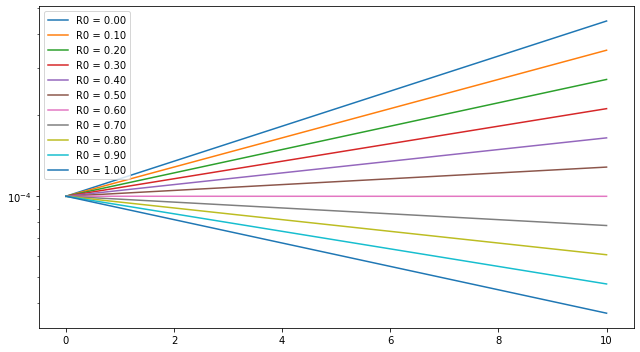

In [18]:
# Probability of transmission
beta = 0.25
# Duration of illness
tau = 10

# Simulation time and timestep
Tmax = 10 # Time in days
# List of times to provide solution at
T = np.linspace(0, Tmax, 101) # 10 points per day

R0s = np.linspace(0, 1, 11)

fig = plt.figure(figsize = (9, 5))

for i, R0 in enumerate(R0s):
    # initial conditions
    I0 = 1e-4
    S0 = 1 - I0 - R0
    # Put into vector
    X0 = np.array([S0, I0, R0])
    # Right-hand side of ODE
    f = lambda x, t: SIR_deterministic(x, t, beta, tau)
    # Run simulation
    X = odeint(f, X0, T)
    # Unpack variables
    S, I, R = X.T

    plt.plot(T, I, label = f'R0 = {R0:.2f}')
    
plt.legend()
plt.yscale('log')
plt.tight_layout()

### Then a more rigorous bisection approach

Based on the semi-log plot, it seems that exponential growth in the initial phase is a reasonable assumption, and it seems the exponent is strictly decreasing with increasing $R(0)$. So using a bisection scheme to search the range from $R(0) = 0.5$ to $R(0)=0.7$ should work fine.

In [19]:
# Write a function that calculates the exponent
# Choosing a very short Tmax, since we only care about initial behaviour
def find_exponent(R0, beta = 0.25, tau = 10, Tmax = 1e-6):
    # initial conditions
    I0 = 1e-4
    S0 = 1 - I0 - R0
    # Put into vector
    X0 = np.array([S0, I0, R0])
    # Right-hand side of ODE
    f = lambda x, t: SIR_deterministic(x, t, beta, tau)
    # List of times to provide solution at (only need first and last point)
    T = [0, Tmax]
    # Run simulation
    # Choosing strict tolerance due to the very short integration time
    X = odeint(f, X0, T, atol = 1e-15)
    # Unpack variables
    S, I, R = X.T
    # Return exponent
    return np.log(I[-1]/I[0])/Tmax

In [20]:
# Range to scan
R0_min = 0.5
R0_max = 0.7

# Run bisection scheme
print(f'R0 = {bisect(find_exponent, R0_min, R0_max):.8f}')

R0 = 0.59990000


Based on the results below, it looks like the correct value is in fact $R(0) = 0.5999$, and not not 0.6 exactly. To check if this is the case, we take a look at Eq. (1b) from the problem set.

What we essentially are trying to find is the value of $R(0)$ which is such that $\frac{\mathrm{d} I}{\mathrm{d} t} = 0$ at $t=0$. Since we have $S+I+R=1$ (assuming $N=1$), and $I(0) = 10^{-4}$ is fixed, and we vary $R(0)$ (and thus also $S(0)$), we have the following equation (at $t=0$):

$$ \frac{\mathrm{d} I}{\mathrm{d} t}\bigg|_{t=0} = 10^{-4} \cdot \beta \cdot \big(1 - R(0) - 10^{-4}\big) - \frac{10^{-4}}{\tau} = 0,$$

which leads to

$$ 1 - R(0) - 10^{-4} = \frac{1}{\beta \tau} \Rightarrow R(0) = 0.5999.$$

Of course, from a pragmatic point of view, 0.6 is a plenty good enough approximation, since we in practice will have large uncertainties in the parameters $\beta$ and $\tau$, and the SIR model is only a very simplified model of reality.

# Problem 2B

Using numba to compile the stochastic functions gives a pretty decent speedup (50 - 100 times faster).

In [21]:
from numba import jit

In [22]:
@jit(nopython = True)
def SIR_stochastic(X, dt, beta, tau):
    S, I, R = X
    if I == 0:
        return S, I, R
    else:
        N = np.sum(X)
        p1 = 1 - np.exp(-dt*beta*I/N)
        S2I = np.random.binomial(S, p1)
        p2 = 1 - np.exp(-dt/tau)
        I2R = np.random.binomial(I, p2)
        S = S - S2I
        I = I + S2I - I2R
        R = R + I2R
    return S, I, R

@jit(nopython = True)
def run_stochastic_SIR(X0, Tmax, dt, beta = 0.25, tau = 10):
    Nt = int(Tmax/dt)
    X = np.zeros((Nt+1, *X0.shape), dtype = np.int32)
    X[0,:] = X0
    t = 0
    for i in range(1, Nt+1):
        dt = min(dt, Tmax - t)
        X[i,:] = SIR_stochastic(X[i-1,:], dt, beta, tau)
        t += dt
    return X

## Problem 2B - Deciding on a timestep

Compare the results to the simulations with the deterministic model, and decide on a timestep. The method we use in the stochastic scheme is kind of similar to the forward Euler method, since we use only one set of current values, and calculate the change from those. Hence, we expect the stochastic scheme to require a shorter timestep than the deterministic scheme (at least if we used a high-order integrator for the deterministic scheme).

On the other hand, the stochastic scheme also has random variations, and there is no particular reason to use a timestep that is too short if the error is anyway dominated by random variations. The point here is to balance those two sources of error, and at the same time keep simulation times within reason.

In [23]:
# Probability of contamination
beta = 0.25
# Duration of illness
tau = 10

f_det  = lambda X, t: SIR_deterministic(X, t, beta, tau)


# Initial conditions, for both models
N = 100000
I0 = 10
S0 = N - I0
R0 = 0

X0 = np.array([S0, I0, R0])

# Time to run simulation for
Tmax = 180

# List of times to provide solution at for deterministic model
# We only care about the final value.
T_det = [0, Tmax]
X_det = odeint(f_det, X0, T_det)
S_det, I_det, R_det = X_det.T

# Timesteps to investigate for stochastic scheme
timesteps = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10])

# Running 1000 simulations instead of 10 to reduce sampling error a bit
# (by a factor sqrt(100), on average, see Notebook 05 on Monte Carlo methods)
Nruns = 1000

# Array to store averaged solutions
S_final_stoch = np.zeros((len(timesteps), Nruns))
R_final_stoch = np.zeros((len(timesteps), Nruns))

with tqdm(total = Nruns*len(timesteps)) as progress:
    for i, dt in enumerate(timesteps):
        for n in range(Nruns):
            progress.update(1)
            X = run_stochastic_SIR(X0, Tmax, dt)
            S_final_stoch[i,n] = X[-1,0] # Selecting the element we want directly
            R_final_stoch[i,n] = X[-1,2] # Selecting the element we want directly
            
# Calculate relative error using deterministic as reference
S_errors = np.abs(S_final_stoch - S_det[-1]) / S_det[-1]
R_errors = np.abs(R_final_stoch - R_det[-1]) / R_det[-1]

100%|██████████| 10000/10000 [00:15<00:00, 648.67it/s]


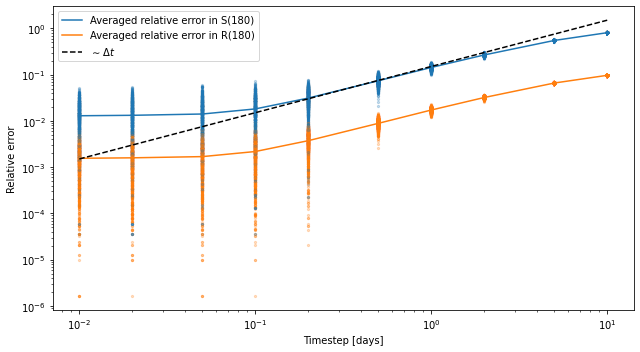

In [24]:
fig = plt.figure(figsize = (9, 5))

lS, = plt.plot(timesteps, np.mean(S_errors, axis = 1), label = 'Averaged relative error in S(180)')
lR, = plt.plot(timesteps, np.mean(R_errors, axis = 1), label = 'Averaged relative error in R(180)')
for n in range(Nruns):
    plt.scatter(timesteps, S_errors[:,n], s = 5, alpha = 0.25, c = lS.get_color())
    plt.scatter(timesteps, R_errors[:,n], s = 5, alpha = 0.25, c = lR.get_color())

plt.plot(timesteps, 0.15*timesteps, '--', c = 'k', label = '$\sim \Delta t$')
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Timestep [days]')
plt.ylabel('Relative error')
plt.legend()
plt.tight_layout()

Based on the plot above, it looks like sampling error is going to dominate the error for any timestep shorter than about 1 day. Still, we would like to select a timestep that gives a reasonably low average error.

Choosing a timestep of $\Delta t = 0.05\,\mathrm{days}$ seems like it will give an average error of around 1% in the final value of $S$, and $\Delta t = 0.01\,\mathrm{days}$ will give an average error around 0.2% (for the parameters we have used here). Either of these seem acceptable. Since the simulation run time is still quite short with a timestep of 0.01 days, we'll use that for now (but we might for practical reasons need to use a longer step in the larger simulations in problem 2E).

## Problem 2B - Task a

In [25]:
# Probability of contamination
beta = 0.25
# Duration of illness
tau = 10

f_det = lambda X, t: SIR_deterministic(X, t, beta, tau)


# Initial conditions, for both models
N = 100000
I0 = 10
S0 = N - I0
R0 = 0
X0 = np.array([S0, I0, R0])

Tmax = 180
# List of times to provide solution at for deterministic solution
# (chosen to match timstep of stochastic model)
T, dt = np.linspace(0, Tmax, 18001, retstep = True) # 100 points per day
# Run simulation
X_det = odeint(f_det, X0, T)
S_det, I_det, R_det = X_det.T

# Run simulations with stochastic model
Nruns = 10
SIRs = []
for i in trange(Nruns):
    SIRs.append(run_stochastic_SIR(X0, Tmax, dt))

100%|██████████| 10/10 [00:00<00:00, 285.13it/s]


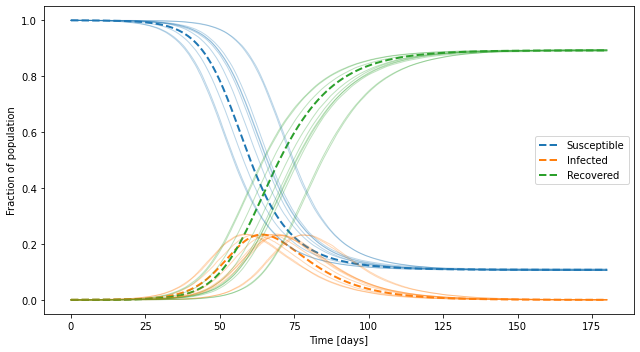

In [26]:
fig = plt.figure(figsize = (9, 5))

lS, = plt.plot(T, S_det/N, '--', lw = 2, label = 'Susceptible')
lI, = plt.plot(T, I_det/N, '--', lw = 2, label = 'Infected')
lR, = plt.plot(T, R_det/N, '--', lw = 2, label = 'Recovered')


for X in SIRs:
    S, I, R = X.T
    plt.plot(T, S/N, c = lS.get_color(), lw = 1, alpha = 0.3)
    plt.plot(T, I/N, c = lI.get_color(), lw = 1, alpha = 0.3)
    plt.plot(T, R/N, c = lR.get_color(), lw = 1, alpha = 0.3)

plt.legend()
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.tight_layout()
plt.savefig('SIR.png')

## Problem 2B - Task b: Plot exponential growth

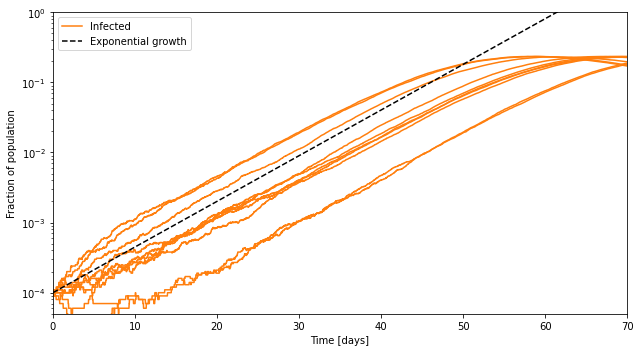

In [27]:
# Plot early phase infected on semi-log plot
fig = plt.figure(figsize = (9, 5))

for i, X in enumerate(SIRs):
    S, I, R = X.T
    if i == 0:
        lI, = plt.plot(T, I/N, c = '#ff7f0e', label = 'Infected')
    else:
        plt.plot(T, I/N, c = lI.get_color())

plt.plot(T, I0*np.exp(T*(beta-1/tau))/N, '--', c = 'k', label = 'Exponential growth')
plt.legend()
plt.yscale('log')
plt.xlim(0, 70)
plt.ylim(5e-5, 1)
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.tight_layout()

### Problem 2B - Task c: Probability of outbreak disappearing by itself

The following strategy was chosen:
* If there are no infected people (I == 0) after 50 days, the outbreak is assumed to have disappeared by itself.
* Run a number ```Ntrials``` of simulations, and estimate the probability of the outbreak disappearing.
* Run a number ```Nruns``` of experiments, and use the results to estimate the standard deviation of the estimated probability.
* Repeat this for all 10 initial conditions.

In [28]:
# Probability of contamination
beta = 0.25
# Duration of illness
tau = 10
# Simulation time and timestep
Tmax = 50 # days
dt = 0.01

I0s = np.arange(1, 11)

Nruns = 100
Ntrials = 100

results = np.zeros((len(I0s), Nruns))

for i, I0 in tqdm(enumerate(I0s), total = len(I0s)):
    # Initial conditions
    N = 100000
    R0 = 0
    S0 = N - I0 - R0
    # Put into vector
    X0 = np.array([S0, I0, R0])

    for n in range(Nruns):
        count = 0
        for j in range(Ntrials):
            X = run_stochastic_SIR(X0, Tmax, dt)
            S, I, R = X.T
            if I[-1] > 0:
                count += 1
        results[i,n] = count
    

100%|██████████| 10/10 [01:15<00:00,  7.54s/it]


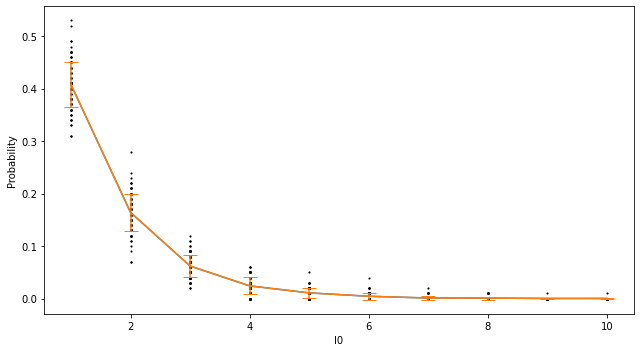

In [29]:
fig = plt.figure(figsize = (9, 5))

for i in range(Nruns):
    plt.scatter(I0s, 1-results[:,i]/Ntrials, marker = '.', s = 5, c = 'k')
    
plt.plot(I0s, np.mean(1 - results/Ntrials, axis = 1))
plt.errorbar(I0s, np.mean(1 - results/Ntrials, axis = 1), yerr = np.std(1 - results/Ntrials, axis = 1), capsize = 7)
    
plt.ylabel('Probability')
plt.xlabel('I0')
plt.tight_layout()

The values will vary a bit, depending on the definition of "outbreak". Stricter definitions may lead to lower probabilities.

# Problem 2C: Stochastic SEIIaR model

In [30]:
@jit(nopython = True)
def SEIIaR_stochastic(X, dt, beta, rs, ra, fa, fs, tau_E, tau_I):
    S, E, I, Ia, R = X
    N = np.sum(X)
    # Transition from susceptible to exposed
    pSE = 1 - np.exp(-dt*beta*(rs*I + ra*Ia)/N)
    S2E = np.random.binomial(S, pSE)
    # Transition from exposed to infected,
    # with branching between asymptomatic and symptomatic
    pEI  = fs*(1 - np.exp(-dt/tau_E))
    pEIa = fa*(1 - np.exp(-dt/tau_E))
    E2I, E2Ia, _ = np.random.multinomial(E, (pEI, pEIa, 1-pEI-pEIa))
    # Transition from infected to recovered
    pIR = 1 - np.exp(-dt/tau_I)
    I2R = np.random.binomial(I, pIR)
    Ia2R = np.random.binomial(Ia, pIR)
    # Calculate new values
    S  = S  - S2E
    E  = E  + S2E - E2I - E2Ia
    I  = I  + E2I  - I2R
    Ia = Ia + E2Ia - Ia2R
    R  = R  + I2R + Ia2R
    return S, E, I, Ia, R

@jit(nopython = True)
def run_stochastic_SEIIaR(X0, Tmax, dt, beta=0.55, rs=1, ra=0.1, fa=0.4, fs=0.6, tau_E=3, tau_I=7):
    Nt = int(Tmax/dt)
    X = np.zeros((Nt+1, *X0.shape), dtype = np.int32)
    X[0,:] = X0
    t = 0
    for i in range(1, Nt+1):
        dt = min(dt, Tmax - t)
        X[i,:] = SEIIaR_stochastic(X[i-1,:], dt, beta, rs, ra, fa, fs, tau_E, tau_I)
        t += dt
    return X

## Problem 2C - Deciding on a timestep

In [31]:
# Initial conditions
N = 100000
E0 = 25
I0 = 0
Ia0 = 0
R0 = 0
S0 = N - (I0+I0+Ia0+R0)
# Put into vector
X0 = np.array([S0, E0, I0, Ia0, R0])

# Time to run simulation for
Tmax = 180

# Reference timestep
dt_ref = 0.0025

# Timesteps to investigate for stochastic scheme
timesteps = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10])

# Running 1000 simulations instead of 10 to reduce sampling error a bit
# (by a factor sqrt(100), on average, see Notebook 05 on Monte Carlo methods)
Nruns = 1000
# Using more runs in reference solution
Nruns_ref = 5000

# Array to store averaged solutions
S_final = np.zeros((len(timesteps), Nruns))
R_final = np.zeros((len(timesteps), Nruns))

# Reference solutions
S_ref = 0
R_ref = 0

# Obtain reference solution
for i in trange(Nruns_ref):
    X = run_stochastic_SEIIaR(X0, Tmax, dt_ref)
    S_ref += X[-1,0] / Nruns_ref
    R_ref += X[-1,4] / Nruns_ref

with tqdm(total = Nruns*len(timesteps)) as progress:
    for i, dt in enumerate(timesteps):
        for n in range(Nruns):
            progress.update(1)
            X = run_stochastic_SEIIaR(X0, Tmax, dt)
            S_final[i,n] = X[-1,0] # Selecting the element we want directly
            R_final[i,n] = X[-1,4] # Selecting the element we want directly
            
# Calculate relative error using deterministic as reference
S_errors = np.abs(S_final - S_ref) / S_ref
R_errors = np.abs(R_final - R_ref) / R_ref

100%|██████████| 10000/10000 [00:28<00:00, 349.98it/s]


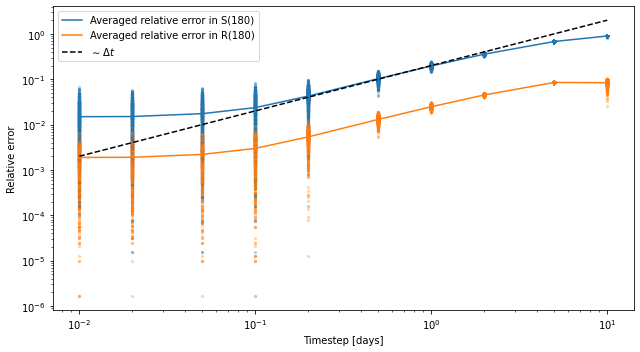

In [32]:
fig = plt.figure(figsize = (9, 5))

lS, = plt.plot(timesteps, np.mean(S_errors, axis = 1), label = 'Averaged relative error in S(180)')
lR, = plt.plot(timesteps, np.mean(R_errors, axis = 1), label = 'Averaged relative error in R(180)')
for n in range(Nruns):
    plt.scatter(timesteps, S_errors[:,n], s = 5, alpha = 0.25, c = lS.get_color())
    plt.scatter(timesteps, R_errors[:,n], s = 5, alpha = 0.25, c = lR.get_color())

plt.plot(timesteps, 0.2*timesteps, '--', c = 'k', label = '$\sim \Delta t$')
    
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Timestep [days]')
plt.ylabel('Relative error')
plt.legend()
plt.tight_layout()

Based on the plot above, it looks like the error in the SEIIaR model for different timesteps is quite similar to what we found for the SIR model. Hence, we will use a timestep $\Delta t = 0.01\;\mathrm{days}$ for now, but we might have to go up in timestep for the larger simulations to come later.

## Problem 2C - Task a: Implement the model and compare to deterministic SIR

In [33]:
# Initial conditions
N = 100000
E0 = 25
I0 = 0
Ia0 = 0
R0 = 0
S0 = N - (I0+I0+Ia0+R0)
# Put into vector
X0 = np.array([S0, E0, I0, Ia0, R0])

T0 = 0
Tmax = 180
dt = 0.01

SIRs = []
for i in trange(10):
    SIRs.append(run_stochastic_SEIIaR(X0, Tmax, dt))

# Times. Use these as output times for deterministic as well.
T = np.linspace(0, Tmax, SIRs[0].shape[0])

# Run deterministic
f_det = lambda X, t: SIR_deterministic(X, t, beta, tau)
# Initial condition for deterministic
X0 = np.array([99990, 10, 0])
X = odeint(f_det, X0, T)

100%|██████████| 10/10 [00:00<00:00, 114.03it/s]


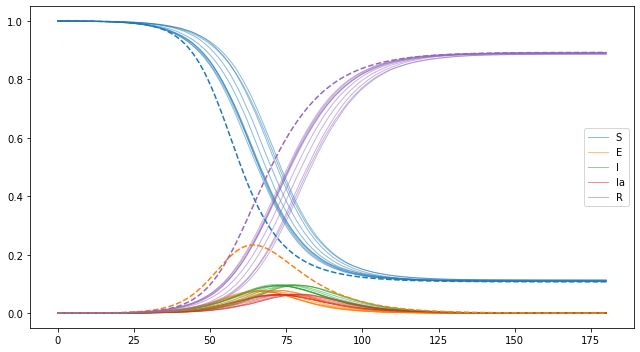

In [34]:
fig = plt.figure(figsize = (9, 5))

colors = []
labels = ['S', 'E', 'I', 'Ia', 'R']

for n, SIR in enumerate(SIRs):
    for i in range(SIR.shape[1]):
        if n == 0:
            l, = plt.plot(T, SIR[:,i]/N, lw = 1, alpha = 0.5, label = labels[i])
            colors.append(l.get_color())
        else:
            plt.plot(T, SIR[:,i]/N, lw = 1, alpha = 0.5, c = colors[i])

S, I, R = X.T
plt.plot(T, S/N, '--', c = colors[0])
plt.plot(T, I/N, '--', c = colors[1])
plt.plot(T, R/N, '--', c = colors[4])

plt.legend()
plt.tight_layout()

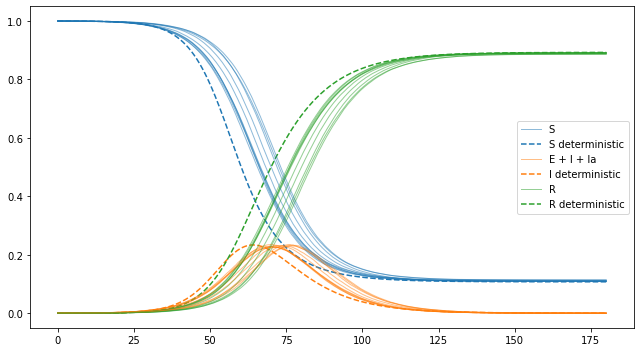

In [35]:
# Alternative plot with E + I + Ia shown as one curve

fig = plt.figure(figsize = (9, 5))

S, I, R = X.T

for n, SIR in enumerate(SIRs):
    if n == 0:
        lS, = plt.plot(T, SIR[:,0]/N, lw = 1, alpha = 0.5, label = 'S')
        plt.plot(T, S/N, '--', c = lS.get_color(), label = 'S deterministic')
        lI, = plt.plot(T, np.sum(SIR[:,1:4], axis = 1)/N, lw = 1, alpha = 0.5, label = 'E + I + Ia')
        plt.plot(T, I/N, '--', c = lI.get_color(), label = 'I deterministic')
        lR, = plt.plot(T, SIR[:,4]/N, lw = 1, alpha = 0.5, label = 'R')
        plt.plot(T, R/N, '--', c = lR.get_color(), label = 'R deterministic')
    else:
        plt.plot(T, SIR[:,0]/N, lw = 1, alpha = 0.5, c = lS.get_color())
        plt.plot(T, np.sum(SIR[:,1:4], axis = 1)/N, lw = 1, alpha = 0.5, c = lI.get_color())
        plt.plot(T, SIR[:,4]/N, lw = 1, alpha = 0.5, c = lR.get_color())


plt.legend()
plt.tight_layout()

## Problem 2C - Task b: Self-isolation of people with symptoms

### First, a visual approach

In [36]:
# Initial conditions
N = 100000
E0 = 25
Ia0 = 0
Is0 = 0
R0 = 0
S0 = N - (I0+Ia0+Is0+R0)

X0 = np.array([S0, E0, Ia0, Is0, R0])

T0 = 0
Tmax = 20
dt = 0.01
Nt = int(Tmax/dt)
T = np.linspace(0, Tmax, Nt+1)

Nruns = 100
rs_list = np.linspace(0.1, 0.7, 7)

infected_mean_values = []

for i, rs in tqdm(enumerate(rs_list), total = len(rs_list)):
    infected_mean = np.zeros(Nt+1)
    for i in range(Nruns):
        S, E, I, Ia, R = run_stochastic_SEIIaR(X0, Tmax, dt, rs = rs).T
    
        infected_mean += E
        infected_mean += I
        infected_mean += Ia
    
    infected_mean_values.append(infected_mean / Nruns)

100%|██████████| 7/7 [00:01<00:00,  6.57it/s]


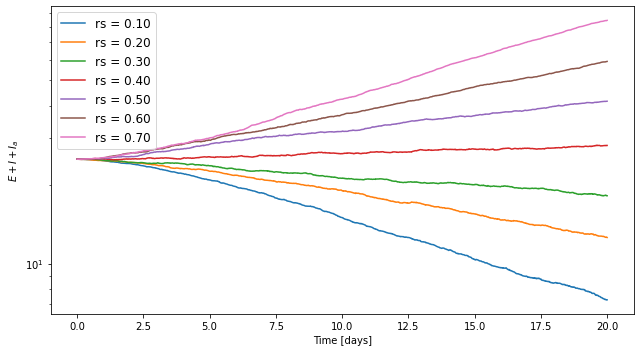

In [37]:
fig = plt.figure(figsize = (9, 5))

for i, rs in enumerate(rs_list):
    plt.plot(T, infected_mean_values[i], label = f'rs = {rs:.2f}')
    
plt.legend(fontsize = 12, loc = 'upper left')
plt.xlabel('Time [days]')
plt.ylabel('$E + I + I_a$')
plt.yscale('log')
plt.tight_layout()

### A more rigorous approach with uncertainty estimate

Bisection or similar will be difficult, due to the stochastic nature of the problem. Settling for lots of simulations in the relevant range, based on the plot above.

Assuming exponential early phase growth (which is not really true in this case), and calculating exponent based on starting value and value at T=10 days. Note that in this case we cannot use a really short time, since the number of infections cannot start growing until some of the exposed people have transitioned into infected. This is different from the approach in problem 2A Task d, where we could use a very short time.

In [38]:
def find_growth_factor_SEIIaR(rs, dt = 0.01, Tmax = 10):
    # initial conditions
    N = 100000
    E0 = 25
    I0 = 0
    Ia0 = 0
    R0 = 0
    S0 = N - (I0+I0+Ia0+R0)
    # Put into vector
    X0 = np.array([S0, E0, I0, Ia0, R0])
    # Run simulation
    S, E, I, Ia, R = run_stochastic_SEIIaR(X0, Tmax, dt, rs = rs).T
    # Return growth factor, based on change in E + I + Ia from t=0 to t=Tmax
    return (E[-1]+I[-1]+Ia[-1]) / (E0+I0+Ia0)

In [39]:
Nruns = 500
rs_list = np.linspace(0.0, 1.0, 101)

factors = np.zeros((len(rs_list), Nruns))

for i, rs in tqdm(enumerate(rs_list), total = len(rs_list)):
    for n in range(Nruns):
        factors[i,n] = find_growth_factor_SEIIaR(rs, Tmax = 10)

100%|██████████| 101/101 [00:19<00:00,  5.15it/s]


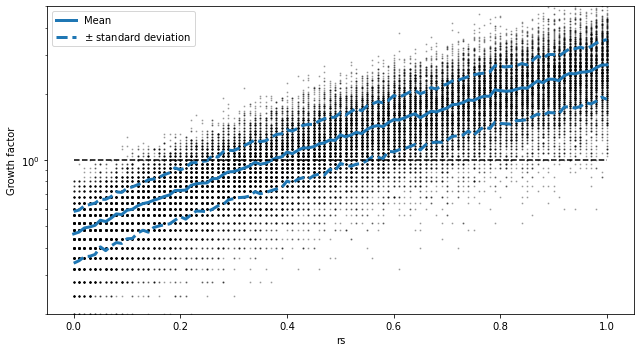

In [40]:
fig = plt.figure(figsize = (9, 5))

for i in range(Nruns):
    plt.scatter(rs_list, factors[:,i], marker = '.', s = 4, c = 'k', alpha = 0.25)

mu = np.mean(factors, axis = 1)
sigma = np.std(factors, axis = 1)
l, = plt.plot(rs_list, mu, lw = 3, label = 'Mean')
plt.plot(rs_list, mu + sigma, '--', c = l.get_color(), lw=3, label = '$\pm$ standard deviation')
plt.plot(rs_list, mu - sigma, '--', c = l.get_color(), lw=3)

    
plt.plot(rs_list, [1.0]*len(rs_list), '--', c = 'k')

plt.ylabel('Growth factor')
plt.xlabel('rs')
plt.legend()
plt.yscale('log')
plt.ylim(0.2, 5)
plt.tight_layout()

Based on the plot above, it looks like outbreaks on average grow over the first 10 days if $r_s$ is larger than about 0.38. If $r_s$ is smaller than about 0.24, then 85% of outbreaks will decrease in size over the first 10 days.

### Alternative approach: Find probability of outbreak decaying


100%|██████████| 51/51 [00:38<00:00,  1.32it/s]


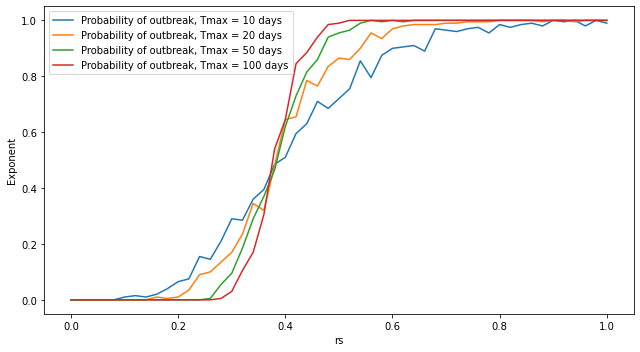

In [41]:
fig = plt.figure(figsize = (9, 5))
Nruns = 200
rs_list = np.linspace(0.0, 1.0, 51)

for Tmax in [10, 20, 50, 100]:
    factors = np.zeros((len(rs_list), Nruns))

    for i, rs in tqdm(enumerate(rs_list), total = len(rs_list)):
        for n in range(Nruns):
            factors[i,n] = find_growth_factor_SEIIaR(rs, Tmax = Tmax)
    probability = np.sum(factors > 1, axis = 1) / factors.shape[1]

    plt.plot(rs_list, probability, label = f'Probability of outbreak, Tmax = {Tmax} days')

plt.ylabel('Exponent')
plt.xlabel('rs')
plt.legend()
#plt.ylim(-0.2, 0.2)
plt.tight_layout()

# Problem 2D: Stochastic SEIIaR commuter model

The code below is maybe a little more convoluted than it has to be, but after a bit of experimentation I found this was about as fast as I could make it.

Main points:
* I use numba to speed up the code.
* I make use of an if-test to do nothing for those population groups where nothing happens, either because
 * There are zero people (all the zero-elements of the population matrix)
 * There are no people in the categories E, I and Ia, _and_ the probability of exposure is zero or S = 0
* I tried using vectorised binomial and multinomial from np.random.default_rng(), but numba doesn't support default_rng it seems, and the result was far slower.
* With the code below, the 10 x 10 matrix in problem 2E takes about 260 - 280 milliseconds to run for 180 days with dt = 0.01 days. I found I could make the code maybe 20% faster, but at the expense of a much less readable code, so I didn't consider it worth the tradeoff.

In [42]:
@jit(nopython = True)
def SEIIaR_commuter_Nsteps(population, Nsteps, dt):
    # Hard-coding model parameters here
    beta=0.55
    f = np.array([0.6, 0.4]) # f_s and f_a
    r = np.array([1.0, 0.1]) # r_s and r_a
    tau_E = 3.0
    tau_I = 7.0
    # Calculate those probabilities that
    # do not depend on the other variables
    pEI, pEIa = f*(1 - np.exp(-dt/tau_E))
    pIR = 1 - np.exp(-dt/tau_I)
    # Number of towns
    Ntowns = population.shape[0]
    
    for i in range(Ntowns):
        for n in range(Nsteps):
            X = np.sum(population[i,:,:], axis = 0)
            # Transition from susceptible to exposed
            pSE = 1 - np.exp(-dt*beta*(np.sum(r*X[2:4]))/np.sum(X))
            for j in range(Ntowns):
                # Unpack variables for convenience
                S, E, I, Ia, R = population[i,j,:]
                # If (E + I + Ia) == 0 and pSE = 0, nothing will happen, so do nothing
                # (this saves a fair bit of simulation time in problem 2E)
                if ((E + I + Ia) > 0) or ((pSE > 0) and (S > 0)):
                    S2E = np.random.binomial(S, pSE)
                    E2I, E2Ia, _ = np.random.multinomial(E, (pEI, pEIa, 1-pEI-pEIa))
                    I2R = np.random.binomial(I, pIR)
                    Ia2R = np.random.binomial(Ia, pIR)
                    # Calculate new values
                    S  = S  - S2E
                    E  = E  + S2E  - E2I - E2Ia
                    I  = I  + E2I  - I2R
                    Ia = Ia + E2Ia - Ia2R
                    R  = R  + I2R  + Ia2R
                    population[i,j,:] = (S, E, I, Ia, R)
    return population


@jit(nopython = True)
def SEIIaR_commuter_one_day(population, dt):

    # Calculate number of timesteps in a day
    Nsteps = int(1/dt)
    # Confirm that the number of steps is even,
    # otherwise adjust timestep to correct
    if Nsteps % 2 != 0:
        Nsteps = Nsteps + 1
        dt = 1/Nsteps
    # Loop over all the daytime steps
    population = SEIIaR_commuter_Nsteps(population, Nsteps//2, dt)
    # Transpose matrix...
    population = np.transpose(population, axes = (1, 0, 2))
    # ...then loop over all the nighttime steps
    population = SEIIaR_commuter_Nsteps(population, Nsteps//2, dt)
    # Transpose back, then return
    population = np.transpose(population, axes = (1, 0, 2))
    return population
    
@jit(nopython = True)
def run_SEIIaR_commuter(population, Ndays, dt):
    history = np.zeros((population.shape[0], 5, int(Ndays)), dtype = np.int64)
    history[:,:,0] = np.sum(population, axis = 1)
    t = 0
    for i in range(1, Ndays):
        population = SEIIaR_commuter_one_day(population, dt)
        history[:,:,i] = np.sum(population, axis = 1)
    return history

### Run a speed test

In [43]:
population0 = np.zeros((10,10,5), dtype = np.int64)
population0[:,:,0] = np.array([
    [198600, 100, 100, 100, 100, 1000, 0, 0, 0, 0],
    [500, 9500, 0, 0, 0, 0, 0, 0, 0, 0],
    [500, 0, 9500, 0, 0, 0, 0, 0, 0, 0],
    [500, 0, 0, 9500, 0, 0, 0, 0, 0, 0],
    [500, 0, 0, 0, 9500, 0, 0, 0, 0, 0],
    [1000, 0, 0, 0, 0, 498200, 200, 200, 200, 200],
    [0, 0, 0, 0, 0, 1000, 19000, 0, 0, 0],
    [0, 0, 0, 0, 0, 1000, 0, 19000, 0, 0],
    [0, 0, 0, 0, 0, 1000, 0, 0, 19000, 0],
    [0, 0, 0, 0, 0, 1000, 0, 0, 0, 19000],
])

# Set initially exposed
E0 = 25
population0[1,1,0] -= E0 # Subtract from susceptible
population0[1,1,1] += E0 # Add to exposed

# Run simulation for 180 days
Ndays = 180
dt = 0.01

# Call one timestep to compile
population_ = population0.copy()
_ = run_SEIIaR_commuter(population_, Ndays, 0.5)

# Run timing
population_ = population0.copy()
%timeit _ = run_SEIIaR_commuter(population_, Ndays, dt)

256 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Problem 2D - Task a: Set up stochastic SEIIaR commuter model

In [44]:
population0 = np.zeros((2,2,5), dtype = np.int64)

# Population distribution
population0[:,:,0] = np.array([
    [9000, 1000],
    [200, 99800],
])

# Set initially exposed
E0 = 25
population0[0,0,0] -= E0 # Subtract from susceptible
population0[0,0,1] += E0 # Add to exposed

# Run simulation for 180 days
Ndays = 180
dt = 0.01

histories = []
for i in trange(10):
    population_ = population0.copy()
    histories.append(run_SEIIaR_commuter(population_, Ndays, dt))


100%|██████████| 10/10 [00:00<00:00, 17.62it/s]


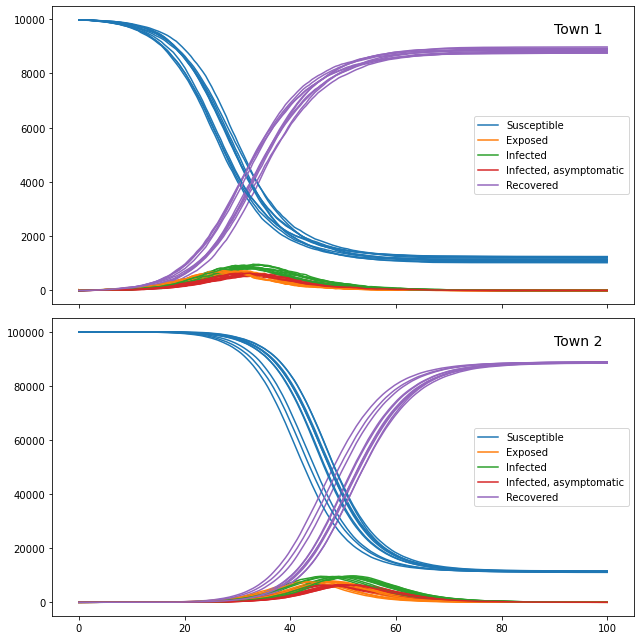

In [45]:
Ntowns = histories[0].shape[0]
times = np.linspace(0, Tmax, histories[0].shape[-1])
fig, ax = plt.subplots(nrows = Ntowns, sharex = True, figsize = (9,9))
for n, history in enumerate(histories):
    for i in range(Ntowns):
        if n == 0:
            ax[i].text(0.9*Tmax, 0.95*np.sum(population0[i,:,:]), f'Town {i+1}', fontsize = 14)
            lS,  = ax[i].plot(times, history[i,0,:], label = 'Susceptible')
            lE,  = ax[i].plot(times, history[i,1,:], label = 'Exposed')
            lIa, = ax[i].plot(times, history[i,2,:], label = 'Infected')
            lIs, = ax[i].plot(times, history[i,3,:], label = 'Infected, asymptomatic')
            lR,  = ax[i].plot(times, history[i,4,:], label = 'Recovered')
            ax[i].legend()
        else:
            ax[i].plot(times, history[i,0,:], c = lS.get_color())
            ax[i].plot(times, history[i,1,:], c = lE.get_color())
            ax[i].plot(times, history[i,2,:], c = lIa.get_color())
            ax[i].plot(times, history[i,3,:], c = lIs.get_color())
            ax[i].plot(times, history[i,4,:], c = lR.get_color())
    
plt.tight_layout()

# Problem 2E: Larger simulations

## Problem 2E - Task a: 10 x 10 system

In [46]:
population0 = np.zeros((10,10,5), dtype = np.int64)
population0[:,:,0] = np.array([
    [198600, 100, 100, 100, 100, 1000, 0, 0, 0, 0],
    [500, 9500, 0, 0, 0, 0, 0, 0, 0, 0],
    [500, 0, 9500, 0, 0, 0, 0, 0, 0, 0],
    [500, 0, 0, 9500, 0, 0, 0, 0, 0, 0],
    [500, 0, 0, 0, 9500, 0, 0, 0, 0, 0],
    [1000, 0, 0, 0, 0, 498200, 200, 200, 200, 200],
    [0, 0, 0, 0, 0, 1000, 19000, 0, 0, 0],
    [0, 0, 0, 0, 0, 1000, 0, 19000, 0, 0],
    [0, 0, 0, 0, 0, 1000, 0, 0, 19000, 0],
    [0, 0, 0, 0, 0, 1000, 0, 0, 0, 19000],
])

# Set initially exposed
E0 = 25
population0[1,1,0] -= E0 # Subtract from susceptible
population0[1,1,1] += E0 # Add to exposed

# Run simulation for 180 days
Ndays = 180
dt = 0.01

histories = []
for i in trange(10):
    population_ = population0.copy()
    histories.append(run_SEIIaR_commuter(population_, Ndays, dt))

100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


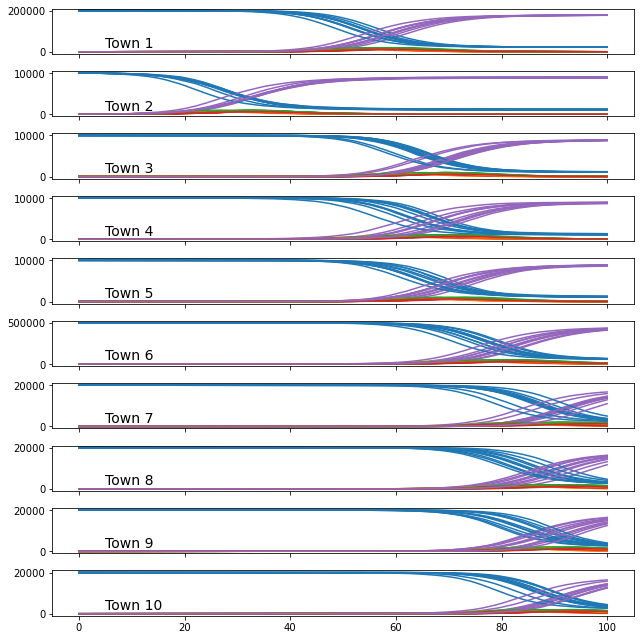

In [47]:
Ntowns = histories[0].shape[0]
times = np.linspace(0, Tmax, histories[0].shape[-1])
fig, ax = plt.subplots(nrows = Ntowns, sharex = True, figsize = (9,9))
for n, history in enumerate(histories):
    for i in range(Ntowns):
        if n == 0:
            ax[i].text(0.05*Tmax, 0.1*np.sum(population0[i,:,:]), f'Town {i+1}', fontsize = 14)
            lS,  = ax[i].plot(times, history[i,0,:], label = 'Susceptible')
            lE,  = ax[i].plot(times, history[i,1,:], label = 'Exposed')
            lIa, = ax[i].plot(times, history[i,2,:], label = 'Infected')
            lIs, = ax[i].plot(times, history[i,3,:], label = 'Infected, asymptomatic')
            lR,  = ax[i].plot(times, history[i,4,:], label = 'Recovered')
#            ax[i].legend()
        else:
            ax[i].plot(times, history[i,0,:], c = lS.get_color())
            ax[i].plot(times, history[i,1,:], c = lE.get_color())
            ax[i].plot(times, history[i,2,:], c = lIa.get_color())
            ax[i].plot(times, history[i,3,:], c = lIs.get_color())
            ax[i].plot(times, history[i,4,:], c = lR.get_color())
    
plt.tight_layout()

### Alternative plot showing exposed and infected (E, I, Ia) only

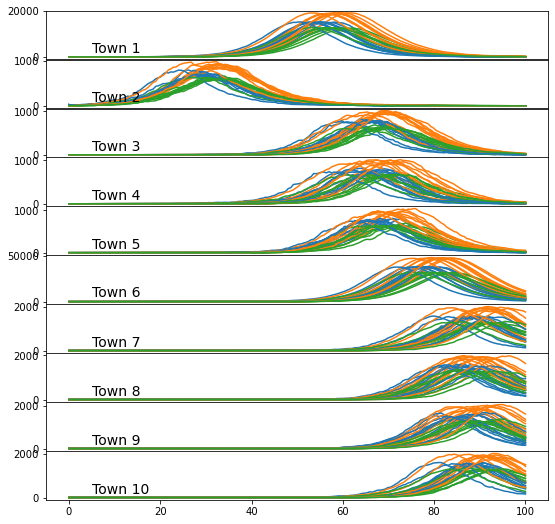

In [48]:
Ntowns = histories[0].shape[0]
times = np.linspace(0, Tmax, histories[0].shape[-1])
fig, ax = plt.subplots(nrows = Ntowns, sharex = True, figsize = (9,9))
for n, history in enumerate(histories):
    for i in range(Ntowns):
        if n == 0:
            ax[i].text(0.05*Tmax, 0.01*np.sum(population0[i,:,:]), f'Town {i+1}', fontsize = 14)
            lE,  = ax[i].plot(times, history[i,1,:], label = 'Exposed')
            lIa, = ax[i].plot(times, history[i,2,:], label = 'Infected')
            lIs, = ax[i].plot(times, history[i,3,:], label = 'Infected, asymptomatic')
        else:
            ax[i].plot(times, history[i,1,:], c = lE.get_color())
            ax[i].plot(times, history[i,2,:], c = lIa.get_color())
            ax[i].plot(times, history[i,3,:], c = lIs.get_color())
    
#ax[9].legend()
plt.subplots_adjust(hspace=0.01)

## Problem 2E - Task b: Population data for Norway

In the simulation below, I have used parallelisation by making the 10 independent simulations run in separate processes. I found it easiest to use ```concurrent.futures.ProcessPoolExecutor``` for this purpose, as it seems to be easier to get hold of the return values, compared to using ```MultiProcessing```.

In order to use this form of parallelisation, the subprocesses must be able to import the function to run, hence the function must be defined in a separate .py file, and not in the notebook. In the file ```SEIIaR_commuter.py``` I have simply included the same three SEIIaR_commuter functions as defined above.

With this form of parallelisation, I can run the 10 simulations for the working population of Norway is about 60 seconds, with a timestep of 0.1 days.

In [49]:
from concurrent.futures import ProcessPoolExecutor
# I have defined the SEIIaR_commuter functions in a separate file
# called SEIIaR_commuter.py, which I import here.
import sys
sys.path.append('.')
import SEIIaR_commuter

In [50]:
# Load population matrix from file
population_distribution = np.loadtxt('population_distribution.csv', delimiter = ',', dtype = np.int64)

In [51]:
population0 = np.zeros((*population_distribution.shape, 5), dtype = np.int64)
population0[:,:,0] = population_distribution


# Set initially exposed
E0 = 50
population0[0,0,0] -= E0 # Subtract from susceptible
population0[0,0,1] += E0 # Add to exposed

# Run simulation for 180 days
Ndays = 180
dt = 0.1

# Make 10 copies of the input arguments, and apply the run_SEIIaR_commuter function
# to each copy with ProcessPoolExectuor.map
Nruns = 10
args = [[population0.copy() for i in range(Nruns)], Nruns*[Ndays,], Nruns*[dt,]]

tic = time()
with ProcessPoolExecutor(max_workers=4) as executor:
    futures = executor.map(SEIIaR_commuter.run_SEIIaR_commuter, args[0], args[1], args[2])
toc = time()
print(f'Running simulations took {toc-tic:.2f} seconds')

# executor.map returns an iterator, unpack into list here, in case
# we need to run plotting code below several times
histories = []
for fu in futures:
    histories.append(fu)

Running simulations took 70.60 seconds


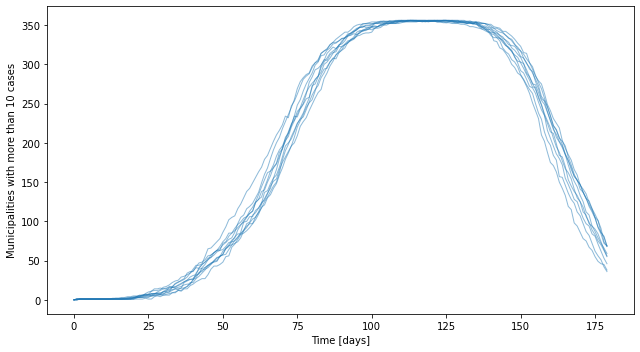

In [52]:
times = np.arange(Ndays)

fig = plt.figure(figsize = (9, 5))

for i, history in enumerate(histories):
    # Sum of elements 2:4 over axis 1 adds up I + Ia
    cases = np.sum(history[:,2:4,:], axis = 1)
    if i == 0:
        l,  = plt.plot(times, np.sum(cases > 10, axis = 0), lw = 1, alpha = 0.5, label = 'Original')
    else:
        plt.plot(times, np.sum(cases > 10, axis = 0), c = l.get_color(), lw = 1, alpha = 0.5)

    
plt.ylabel('Municipalities with more than 10 cases')
plt.xlabel('Time [days]')
plt.tight_layout()

## Problem 2E - Task c: Reduced travel

In [53]:
# First, modify matrix as described
# (simple approach with for-loops)
population_original = np.loadtxt('population_distribution.csv', delimiter = ',', dtype = np.int64)
population_modified = np.zeros_like(population_original)
Ntowns = population_modified.shape[0]
for i in range(Ntowns):
    for j in range(Ntowns):
        if i != j:
            # Divide traveling population by 10
            population_modified[i,j] = round(population_original[i,j]/10)
    # And then add to the non-traveling population
    population_modified[i,i] = np.sum(population_original[i,:]) - np.sum(population_modified[i,:])
    
# Check that the total population in each municipality is the same as before
assert np.allclose(np.sum(population_modified, axis = 1),  np.sum(population_original, axis = 1))


# Set up matrix for use in simulation
population_modified0 = np.zeros((*population_distribution.shape, 5), dtype = np.int64)
population_modified0[:,:,0] = population_modified

# Set initially exposed
E0 = 50
population_modified0[0,0,0] -= E0 # Subtract from susceptible
population_modified0[0,0,1] += E0 # Add to exposed

# Run simulation for 180 days
Ndays = 180
dt = 0.1

# Make 10 copies of the input arguments, and apply the run_SEIIaR_commuter function
# to each copy with ProcessPoolExectuor.map
Nruns = 10
args = [[population_modified0.copy() for i in range(Nruns)], Nruns*[Ndays,], Nruns*[dt,]]

tic = time()
with ProcessPoolExecutor(max_workers=4) as executor:
    futures = executor.map(SEIIaR_commuter.run_SEIIaR_commuter, args[0], args[1], args[2])
toc = time()
print(f'Running simulations took {toc-tic:.2f} seconds')

# executor.map returns an iterator, unpack into list here, in case
# we need to run plotting code below several times
histories = []
for fu in futures:
    histories.append(fu)

Running simulations took 54.92 seconds


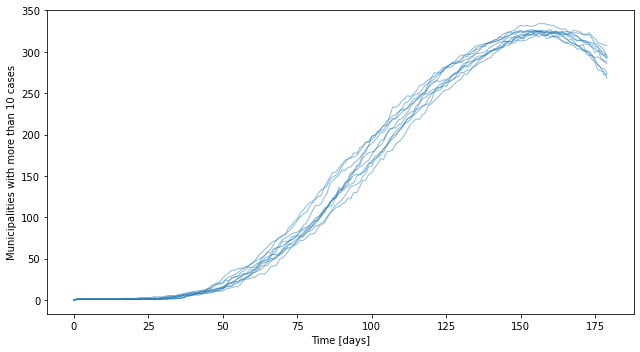

In [54]:
times = np.arange(Ndays)

fig = plt.figure(figsize = (9, 5))

for i, history in enumerate(histories):
    # Sum of elements 2:4 over axis 1 adds up I + Ia
    cases = np.sum(history[:,2:4,:], axis = 1)
    if i == 0:
        l,  = plt.plot(times, np.sum(cases > 10, axis = 0), lw = 1, alpha = 0.5, label = 'Original')
    else:
        plt.plot(times, np.sum(cases > 10, axis = 0), c = l.get_color(), lw = 1, alpha = 0.5)

    
plt.ylabel('Municipalities with more than 10 cases')
plt.xlabel('Time [days]')
plt.tight_layout()